In [1]:
import pandas as pd
from safeaipackage import core

from config import MAIN_MODELS, MODEL_ORDER
from src.load_data import load_predictions

In [2]:
df = load_predictions()
df = df[df.model.isin(MAIN_MODELS)].copy()
model_order = [m for m in MODEL_ORDER if m in df.model.unique()]
df["model"] = pd.Categorical(df["model"], categories=model_order, ordered=True)
df = df[df.age_group == "00+"]
df = df[df["type"] == "median"]

# Compute RGA for each model and horizon
results = []
for h in [1, 2, 3, 4]:
    df_h = df[df.horizon == h]
    for m in df_h.model.unique():
        df_temp = df_h[df_h.model == m]
        score = core.rga(df_temp.value, df_temp.truth)
        results.append({"model": m, "horizon": h, "rga": score})

df_results = pd.DataFrame(results)
df_results["model"] = pd.Categorical(
    df_results["model"], categories=model_order, ordered=True
)
df_results = df_results.sort_values(by=["horizon", "model"]).reset_index(drop=True)

df_wide = df_results.pivot(index="model", columns="horizon", values="rga")
df_wide.columns = [f"horizon_{h}" for h in df_wide.columns]
df_wide = df_wide.reset_index()

In [3]:
df_wide

,model,horizon_1,horizon_2,horizon_3,horizon_4
0,Ensemble,0.970492,0.961038,0.951174,0.951435
1,LightGBM,0.968260,0.951991,0.935191,0.924589
2,TSMixer,0.958663,0.939186,0.922695,0.920029
3,hhh4,0.970350,0.957025,0.948308,0.940494
4,Persistence,0.964462,0.939527,0.911608,0.882775
5,Historical,0.956124,0.959838,0.962260,0.966134


### Generate LaTeX table code


In [4]:
latex_table = df_wide.to_latex(
    float_format="%.3f",  # format floats to 3 decimal places
    caption="RGA scores by model and forecast horizon",
    label="tab:rga_scores",
    column_format="lcccc",
    escape=False,
    index=False
)

print(latex_table)

\begin{table}
\caption{RGA scores by model and forecast horizon}
\label{tab:rga_scores}
\begin{tabular}{lcccc}
\toprule
model & horizon_1 & horizon_2 & horizon_3 & horizon_4 \\
\midrule
Ensemble & 0.970 & 0.961 & 0.951 & 0.951 \\
LightGBM & 0.968 & 0.952 & 0.935 & 0.925 \\
TSMixer & 0.959 & 0.939 & 0.923 & 0.920 \\
hhh4 & 0.970 & 0.957 & 0.948 & 0.940 \\
Persistence & 0.964 & 0.940 & 0.912 & 0.883 \\
Historical & 0.956 & 0.960 & 0.962 & 0.966 \\
\bottomrule
\end{tabular}
\end{table}



# Example

In [5]:
d = pd.DataFrame(
    {
        "x": [1, 2, 3, 4],
        "truth": [4, 9, 10, 1],
        "y1": [3, 10, 9, 2],
        "y2": [21, 22, 30, 17],
    }
)

RGA of y1: 0.9666666666666667
RGA of y2: 1.0


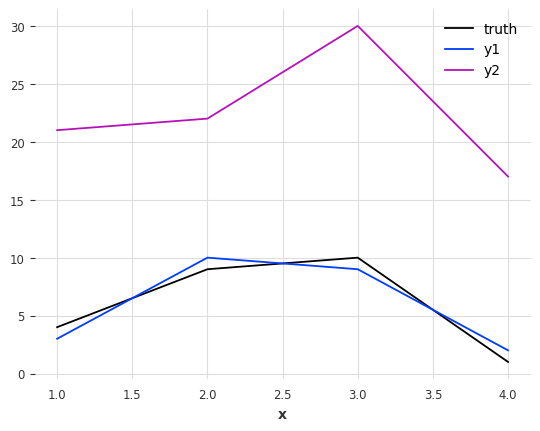

In [6]:
d.set_index("x").plot()
for y in ["y1", "y2"]:
    score = core.rga(d[y], d.truth)
    print(f"RGA of {y}: {score}")